# Rough Outline

## **How we solved: Problem decomposition and Algorithm:**
#### Analyze the requirements:
1. Fair team compositions
2. Understand constraints of the assignment, focusing on diversity in school affiliation, gender, and CGPA distribution within each team.
3. Data Processing
#### Read the CSV data file (records.csv) containing 6000 student records.
1. Organize the data into manageable structures, for example dictionaries or lists, based on tutorial groups for efficient processing.
#### Define Team Formation Logic 
1. Establish criteria for each team to:
    - Ensure no majority from the same school.
    - Achieve gender balance without a majority from one gender.
    - Distribute students with varied CGPAs to maintain academic balance.
#### Implement Team Assignment Algorithm
1. Randomly assign students to teams while applying the diversity constraints.
2. Use nested loops, conditionals, and counters to monitor school, gender, and CGPA distribution during assignment. 
3. Consider fallback mechanisms to adjust assignments when constraints cannot be fully met due to inherent tutorial group imbalances.
#### Save Final Teams 
1. Format the output into a new CSV file with an added “Team Assigned” column.
2. Ensure output readability by sorting or grouping by tutorial group and team number.
#### Evaluate Diversity in Teams
1. Design metrics to evaluate diversity within each team (e.g. bar chart, pie chart, standard deviation). Use Python visualization libraries to illustrate balance effectiveness.
#### Document Computational Thinking Application
1. Computational thinking principles (e.g. abstraction, algorithm, decomposition, pattern recognition applied in team formation and evaluation.
#### Documentation 
1. Jupyter notebook with code, code comments, visual outputs, explanations.



## Step 1: Creating a dictionary with Tutorial Group as Keys, student info as Values
- `studentdict` is a dictionary where each **key** is a tutorial group (e.g., "A1", "B2") and the **value** is a list of students in that group.
- `line.strip().split(",")` splits each line by commas, turning it into a list of items *(e.g., [tutorial_group, student_name, school, gender, gpa]).*
- `newlist = [item[1], item[2], item[3], item[4], item[5]]` creates a new list containing only the student’s details (excluding the tutorial group).
- Check if tutorial group already exists in keys of `studentdict`. If it exists, the student's data is added to that dictionary key. Otherwise, a new key for the tutorial group is created.

In [1]:

studentdict = {}
with open('records.csv','r') as csvfile:
    headers = csvfile.readline() #Read the first line of the file
    for line in csvfile:
        #Create a list of items, splitting the line by commas
        item = line.strip().split(",") 
        newlist = [item[1], item[2], item[3], item[4], item[5]]
        #Checking if tutorial group is already added into the dictionary
        if item[0] in studentdict.keys(): 
             #Add the student's info into the existing tutorial group key in the dictionary
            studentdict[item[0]].append(newlist)
        else:
            #If tutorial group is not in dictionary, initialise a new key with the first student's info as its value
            studentdict[item[0]] = [newlist] 
        


## Step 2: Creating functions to assign the groups (per tutorial group)

### 2. Main `groups` function
#### Purpose: Adds teams to the list based on constraints and distributes any remaining students.
- Input: A list of students, the average CGPA, and the target team size.
- Output: A list of teams, where each team is a list of students who meet the specified diversity constraints.
  



  
.
  





In [2]:
import random

def groups(student, avg, size):
    gpas = [float(stud[4]) for stud in student]  
    avg = sum(gpas) / len(gpas)  
    grp = []  # List to store all formed teams
    teams = 0  #Count number of teams formed
    max_possible_teams = len(student) // size #Iinitalise maximum number of possible teams
    available_students = student.copy()  # Copy of students to keep track of remaining ones

    while teams < max_possible_teams: # Limit to number of possible teams
        if len(available_students) < size:
            print("Not enough students to form another team.")
            break

        # Attempt to form a team
        current_group, team_formed = form_team(
            available_students, avg, size
        )

        #If form_team returns true, team is successfully formed
        if team_formed:
            teams += 1 
            grp.append(current_group) #Add this team into the list of teams
        else:
            break

    # Distribute remaining students to existing teams for students who cannot fit in the constraints
    distribute_remaining_students(available_students, grp)
    return grp








    

### 2.1 `form_team` function
**Purpose: Attempts to form a single team, filling it with students who meet all constraints.**
- Input: A list of students available for grouping, the target team size, and the average CGPA.
- Output: A single team of students (or an incomplete team if the constraints make it impossible to fill the team fully), and updates to the available students list to reflect who’s been placed in the team.

In [3]:
def form_team(available_students, avg, size):
    #Current group that is being added to
    current_group = []
    #Create dictionaries to keep track of school and gender count
    school_count = {}
    gender_count = {"Male": 0, "Female": 0}
    #Count students who are above/below average GPA
    high_count = 0
    low_count = 0

    attempts = 0
    max_attempts = 5000  # Prevent infinite loop in case of difficulty forming team

    # Initialise limits for gender, school, and GPA constraints
    gender_limit, school_limit, cgpa_limit = calculate_limits(size)

    while len(current_group) < size and attempts < max_attempts:
        attempts += 1
        random_student = random.choice(available_students)
        
        # Check if student can be added to the team
        if can_add_student(
            random_student, school_count, gender_count, high_count, low_count,
            gender_limit, school_limit, cgpa_limit, avg
        ):
            # Update counts and add student to current team if can_add function returns True
            high_count, low_count = update_counts(
                random_student, current_group, available_students,
                school_count, gender_count, high_count, low_count, avg
            )

    # If max attempts are reached, and teams are missing students, fill remaining spots without constraints
    if len(current_group) < size and attempts >= max_attempts:
        while len(current_group) < size and available_students:
            current_group.append(available_students.pop(0))

    return current_group, len(current_group) == size 

### 2.1.1 `calculate_limits` function
**Purpose: Calculates the maximum allowable counts for gender, school, and CGPA diversity based on team size.**
- Input: The target team size.
- Output: The maximum numbers for each constraint (gender, school, and CGPA) for this team size.

In [4]:
def calculate_limits(size):
    #Calculate limits for our group constraints
    if size % 2 == 0:
        gender_limit = size  
    else:
        gender_limit = (size // 2) + 1
    school_limit = size // 2
    cgpa_limit = size // 2
    return gender_limit, school_limit, cgpa_limit

### 2.1.2 `can_add_student` function
**Purpose: Checks if a student can be added to the current team based on gender, school, and CGPA constraints.**
- Input: Information about the current student (school, gender, and CGPA) and the current team’s counts for school, gender, and CGPA.
- Output: A simple “yes” or “no” (True/False) on whether this student can join the current team based on the constraints

In [5]:
def can_add_student(student, school_count, gender_count, high_count, low_count, 
                    gender_limit, school_limit, cgpa_limit, avg):

    #Extract their school, gender and CGPA info based on the their indexes in the list
    school, gender, cgpa = student[1], student[3], float(student[4])

    # Check gender constraint
    if gender_count[gender] >= gender_limit:
        return False

    # Check school constraint
    if school not in school_count or school_count[school] < school_limit:
        return True
    else:
        return False

    # Check CGPA constraint
    if cgpa >= avg and high_count >= cgpa_limit:
        return False
    elif cgpa < avg and low_count >= cgpa_limit:
        return False

    return True

### 2.1.3 `update_counts` function
**Purpose: Adds a student to the team and updates relevant counts to reflect the student’s attributes.**
- Input: The selected student, current tracking counts for school, gender, and CGPA, and the list of students still available.
- Output: Updates to the counts (school, gender, CGPA) and the current team list to include the new student and remove selected student from list of available students


In [6]:
def update_counts(student, current_group, available_students,
                  school_count, gender_count, high_count, low_count, avg):

     #Extract their school, gender and CGPA info based on the their indexes in the list
    school, gender, cgpa = student[1], student[3], float(student[4])

    # Add student to team and update relevant counts
    current_group.append(student)
    gender_count[gender] += 1

    # New school in the current group, initiate value in school_count dictionary as 1 and school name as key
    if school in school_count:
        school_count[school] += 1
    #If there's already a student from the same school, update school count 
    else:
        school_count[school] = 1

    #Updates GPA count depending on whether student's GPA higher or lower than average.
    if cgpa >= avg:
        high_count += 1
    else:
        low_count += 1

    # Remove student from available list
    available_students.remove(student)

    return high_count, low_count

### 2.2 `distribute_remaining_students` function
**Purpose: Ensures any students left over after team formation are evenly distributed across formed teams.**
- Input: Any remaining students and the teams already formed.
- Output: The teams, now with any leftover students added evenly across them.

In [7]:
def distribute_remaining_students(available_students, groups):
    extras = len(available_students) #Count how many remaining students are left
    #Iterate through the groups in the list, and distribute remaing students
    for i in range(extras):
        groups[i % len(groups)].append(available_students[i])

### Step 3: We loop the function and call it for every tutorial group in our dictionary
- Get the input for desirable group size.
- For each tutorial group, the program calls the `groups()` function to assign students to teams. 
- Once the desired number of teams is formed, print team details and update the team number for each student.

In [8]:
size = int(input("Size number: "))
if (size>=4 and size<=10):
#The tens digit for our team number
    n = 0  
    #Loop for every tutorial group in our dictionary
    for tutorialgroup in studentdict.keys():
        while True:
            # Extract GPAs
            gpas = [float(stud[4]) for stud in studentdict[tutorialgroup]]  
            # Calculate average GPA
            av = sum(gpas) / len(gpas)  
            #Call the function
            assigned_groups = groups(studentdict[tutorialgroup],av, size)
            #If desirable number of groups groups are formed
            if len(assigned_groups) == 50//size:
                # Debugging statement, print output for visualisation
                print(tutorialgroup) 
                print(f"Average GPA: {av:.2f}")  
                #Iterate for each index in assigned group of five
                for i in range(len(assigned_groups)):  
                    #Print team number
                    print(f"Team: {i + 1 + n}") 
                    #For every student in each group
                    for student in assigned_groups[i]:
                         #Appends team number value to the student info list, updating the dictionary
                        student.append(f"Team {i + 1 + n}")
                    print(assigned_groups[i])
                    #Display average team GPA
                    teamgpa = [float(m[4]) for m in assigned_groups[i]]
                    avgteamgpa = sum(teamgpa)/len(teamgpa)
                    print(f"Team average GPA: {avgteamgpa:.2f}")
                    
                #Increment by number of groups formed
                n += int((len(assigned_groups)))
                # Exit the while loop if 10 teams are formed
                break  
            else:
                 # Repeat the loop again if 10 groups not formed
                continue 
else:
    print("size out of range")
    

Size number:  5


G-1
Average GPA: 4.10
Team: 1
[['4820', 'CoE', 'Meera Singh', 'Female', '4.22', 'Team 1'], ['809', 'CoB (NBS)', 'Nisha Das', 'Female', '4.26', 'Team 1'], ['2818', 'CoB (NBS)', 'Oliver Tan', 'Male', '4.09', 'Team 1'], ['3989', 'WKW SCI', 'Anthony Liu', 'Male', '4.15', 'Team 1'], ['1645', 'CoE', 'Zachary Wu', 'Male', '3.93', 'Team 1']]
Team average GPA: 4.13
Team: 2
[['1075', 'CoB (NBS)', 'Felix Yip', 'Male', '4.08', 'Team 2'], ['5002', 'CCDS', 'Aarav Singh', 'Male', '4.02', 'Team 2'], ['235', 'CCDS', 'Ming Zhang', 'Male', '4.06', 'Team 2'], ['71', 'SoH', 'Savannah Taylor', 'Female', '4.19', 'Team 2'], ['162', 'SSS', 'Lila Patel', 'Female', '4.07', 'Team 2']]
Team average GPA: 4.08
Team: 3
[['4657', 'SoH', 'Oleg Petrovich', 'Male', '4', 'Team 3'], ['567', 'CoB (NBS)', 'Isabella Thompson', 'Female', '4.03', 'Team 3'], ['4479', 'CCDS', 'Amelia Kim', 'Female', '4.11', 'Team 3'], ['588', 'MAE', 'Lucas Walker', 'Male', '4.06', 'Team 3'], ['659', 'SSS', 'Maria Ivanovna', 'Female', '4.2', 'Team

## Step 4: Sorting our dictionary by their team number and transferring it into a list to write it into our CSV file 
- Once all students are assigned to teams, the program sorts them by team number and writes the results into a new CSV file.
- Create a new list to store all students (`sorted_student_list`)
- `sorted(studentdict[tutorialgroup], key=lambda x: int((x[-1])[5:]))`: Sorts students within each tutorial group by their team number (stored at the last index of each student's list).
- `sorted_student_list.extend(minilist)`: Combines the sorted students into one large list.


In [9]:
#Creating a new list
sorted_student_list = []
#Iterate for each tutorial group
for tutorialgroup in studentdict:
    #We sort the tutorial group based on the last index of the student info list, which is their team number, convert it into integer
    #Store this new sorted tutorial group into a smaller list
    minilist = sorted(studentdict[tutorialgroup], key=lambda x: int((x[-1])[5:]))
    #Extend the big list by adding the sorted tutorial group into it
    sorted_student_list.extend(minilist)
    

## Step 5: Read our existing csv file and store the rows in our variable 'lines'



In [10]:
with open('records.csv', 'r') as csvfile:
    lines = csvfile.readlines()


## Step 6: Write on our new csv file from our new sorted student list in Step 4
- The sorted data is then written to a new CSV file (`updated_records.csv`)
- Open the `updated_records.csv` in `write` mode to create or overwrite the file.
- Adds the "Team Assigned" column to the existing header row *(from Step 4)* by taking the original headers (in `lines[0]`) and appending ",Team Assigned". This header row is then written to the new file.

- For each student in `sorted_student_list`:
    - Create a list (`studentinfo`) to store the student’s details, starting with their tutorial group.
    - Checks each tutorial group in `studentdict` to see which team the student belongs to. When found, it adds the tutorial group name to the list of the student's details.
    - Adds the rest of the student’s details (like name, gender, CGPA) from student.
      
- Join the `studentinfo` list into a comma-separated string and writes it as a new line in the CSV.

In [11]:
with open('updated_records.csv', 'w') as new_file:
    # Add the new column name to the header
    header = lines[0].strip() + ',Team Assigned\n' #Read the first row as the headers, adding a new Team Assigned column
    new_file.write(header)

    #For every student in the new list
    
    for student in sorted_student_list:  
        #Create an empty list for us to write into the csv file
        studentinfo = []
        #Append all the student's info from the big list into this small list
        #Append student's tutorial group into the list by checking which tutorialgroup the student belongs to
        for tutorialgroup, students in studentdict.items():
            if student in students:
                studentinfo.append(tutorialgroup)
                #Append rest of student's info into the list
                for data in student:
                    studentinfo.append(data)
                
            
        #Read this small list into csv file
        new_file.write(','.join(studentinfo) + '\n')
                
        

## Visualisation and Evaluation
### Create a list of all the teams for us to analyse and evaluate its diversity

In [12]:
import matplotlib.pyplot as plt

# Manually load data from updated CSV file

list_of_teams = []
team = []
with open('updated_records.csv','r') as csvfile:
    headers = csvfile.readline() #Read the first line of the file
    for line in csvfile:
        #Create a list of items, splitting the line by commas
        student = line.strip().split(",") 
        team.append(student)
        if len(team) == size:
            list_of_teams.append(team)
            team = []
        else:
            continue


        




### Part 1: Gender; Pie Chart to show 

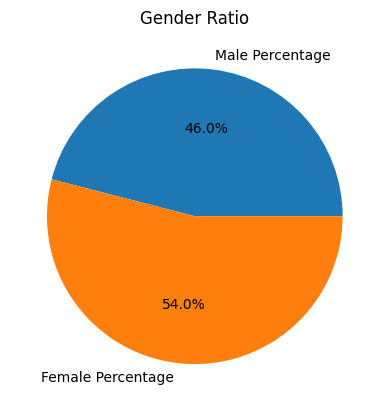

In [13]:
import matplotlib.pyplot as plt

#Initialise accumulator
total_male_percentages = 0
total_female_percentages = 0
male_percentages = []
female_percentages = []
# Calculate gender percentages for each group
for group in list_of_teams:
    male = 0
    female = 0
    
    for student in group:
        if student[4] == 'Male':
            male += 1
        else:
            female += 1
    
    # Calculate the percentage of males and females in the current group and add it to accumulator
    total_male_percentages += (male / size) * 100
    total_female_percentages += (female / size) * 100
    male_percentages.append((male / size) * 100)
    female_percentages.append((female / size) * 100)
    
    
    

# Calculate the average male and female percentages across all groups
avg_male = total_male_percentages / len(list_of_teams)
avg_female = total_female_percentages / len(list_of_teams)


# Create the pie chart data
genders = [avg_male, avg_female]  
labels = ['Male Percentage', 'Female Percentage']

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(genders, labels=labels, autopct='%1.1f%%')
ax.set_title('Gender Ratio')
plt.show()

#### Use a Histogram to show distribution of percentage of *males* in groups

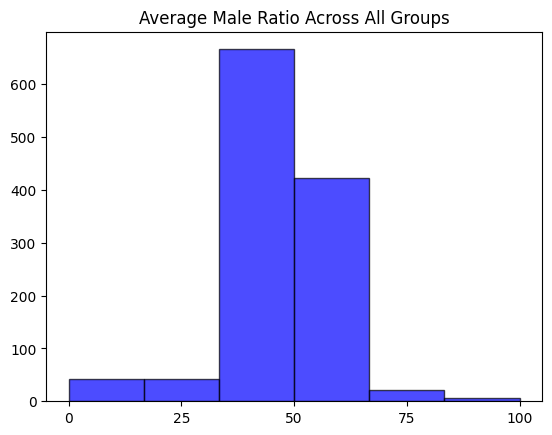

In [14]:

fig, ax = plt.subplots()
plt.xticks([0, 25, 50, 75, 100])

plt.hist(male_percentages, bins=6, color='blue', alpha=0.7, edgecolor='black')

ax.set_title('Average Male Ratio Across All Groups')

# Show the pie chart
plt.show()

#### Use a Histogram to show distribution of percentage of *females* in groups

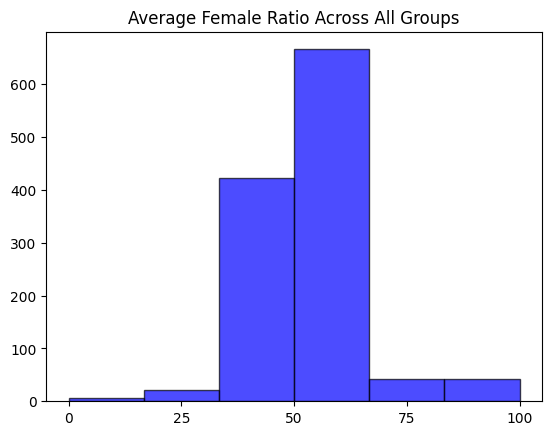

In [15]:
fig, ax = plt.subplots()
plt.xticks([0, 25, 50, 75, 100])

plt.hist(female_percentages, bins=6, color='blue', alpha=0.7, edgecolor='black')
ax.set_title('Average Female Ratio Across All Groups')
plt.show()

### Part 2: GPA; Histogram


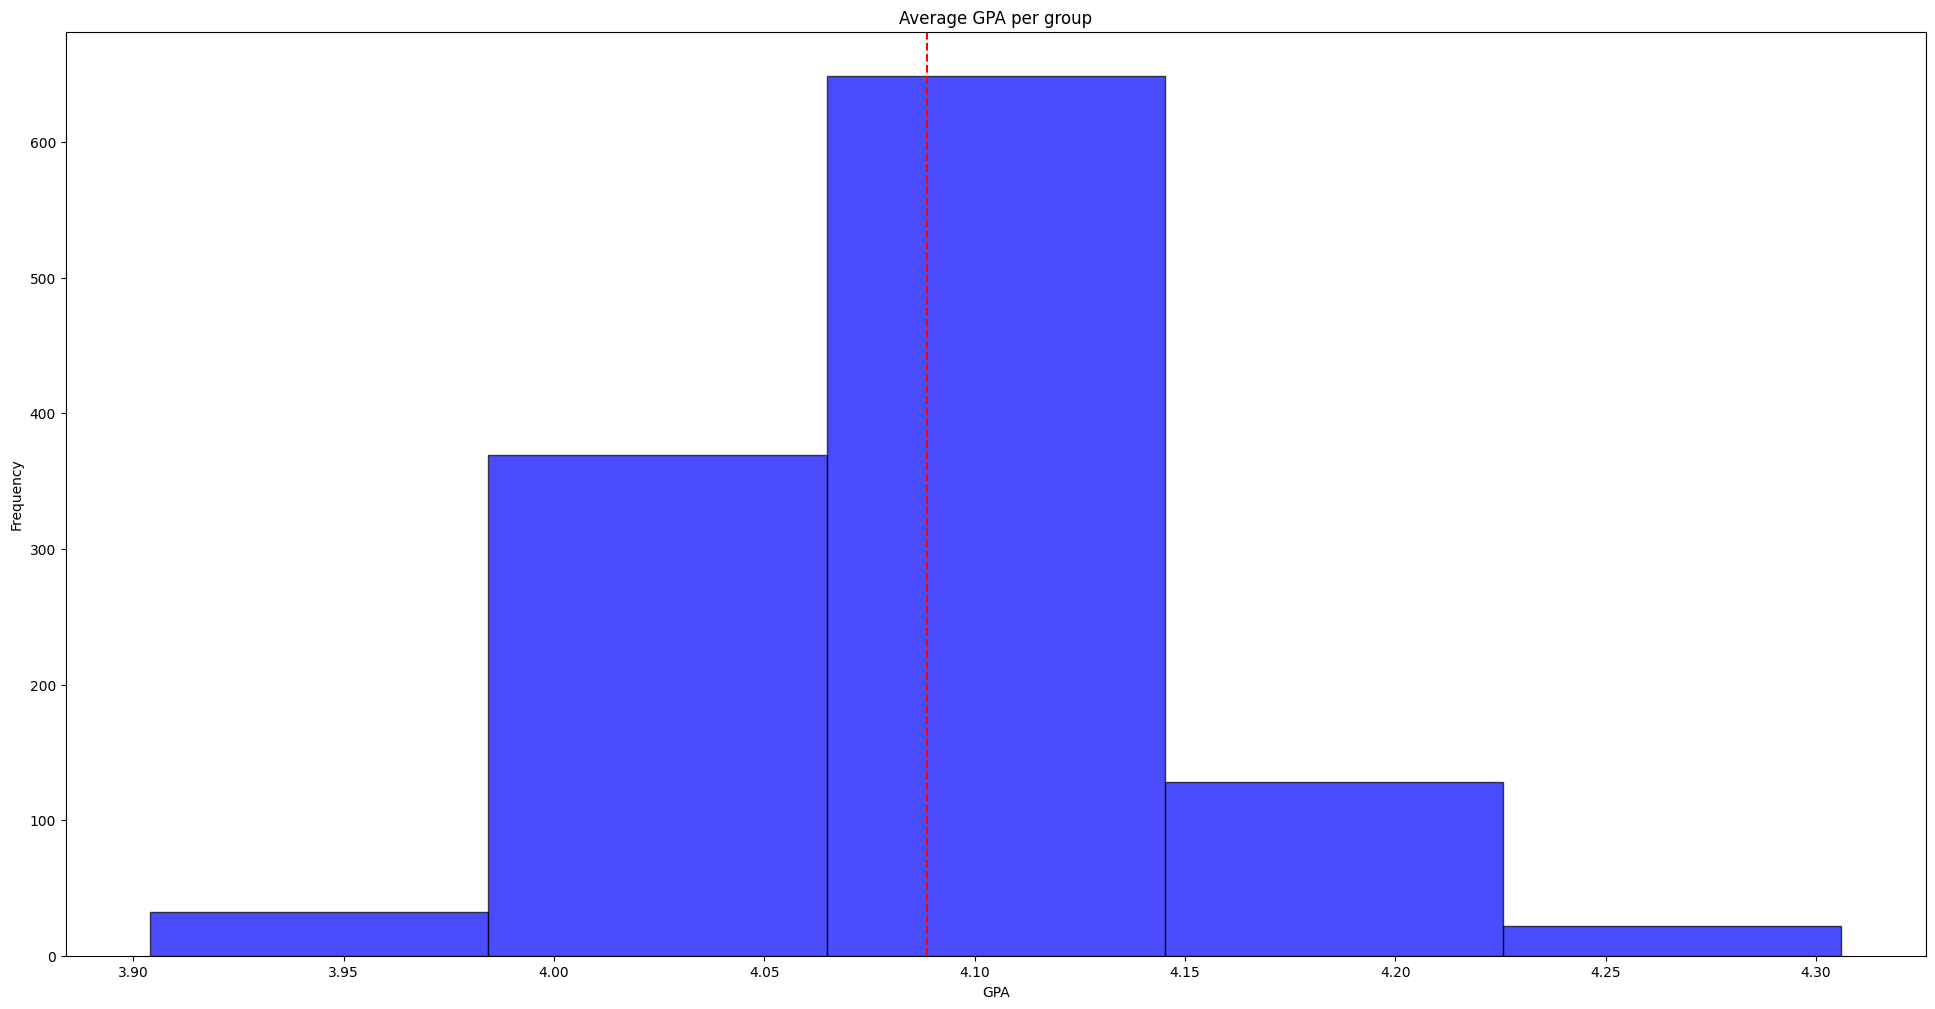

In [16]:
#Create a list of average GPA's per group
avg_gpa_group = []
totalgpa = 0
for group in list_of_teams:
    sumgpa = 0
    for student in group:
        sumgpa += float(student[5])
        totalgpa += float(student[5])
    #Calculate average GPA and add it into the list
    x = sumgpa/size
    avg_gpa_group.append(x)

#Avergae GPA of entire student population
total_avg_gpa = totalgpa/6000

plt.figure(figsize=(24, 12))
plt.title('Average GPA per group')
plt.xlabel('GPA')
plt.ylabel('Frequency')


plt.axvline(x=total_avg_gpa, color='red', linestyle='--', label=f'Average GPA: {total_avg_gpa:.2f}')
#Plot histogram
plt.hist(avg_gpa_group, bins=5, color='blue', alpha=0.7, edgecolor='black')
plt.show()


        


_The red line represents average GPA from the entire student population_

### Part 3: Schools; Bar Chart

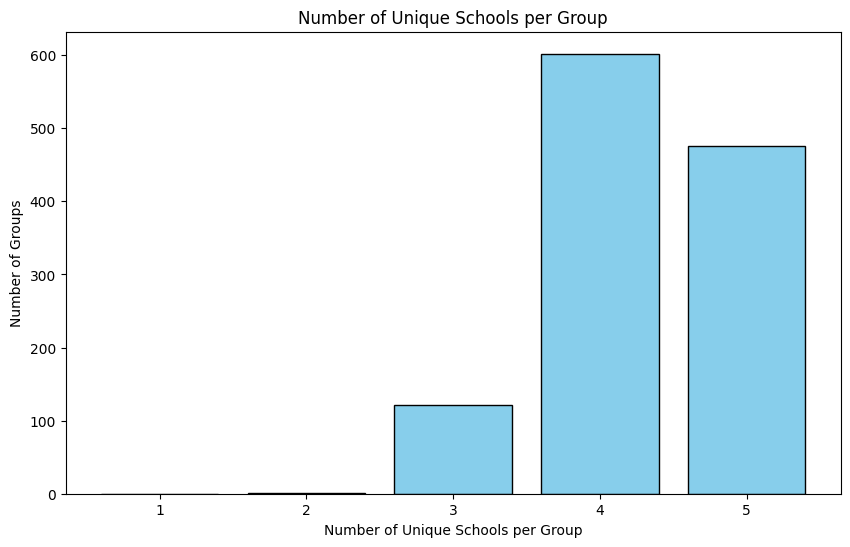

In [17]:
#Create dictionary
unique_schools_per_group = {}
#Set the keys as possible number of different schools
#ie numbers 1 to size of group
for i in range(1, size+1):
        unique_schools_per_group[i] = 0 #initialise value as 0, value acts as counter

#iterate for every team
for group in list_of_teams:
    schoollist = []
    counter = 0
    for student in group:
        school = student[2]
        #checks if student is in different school
        if school not in schoollist:
            counter += 1
            schoollist.append(school)
    #Add value according to the key that matches the number of different schools in the group
    if counter in unique_schools_per_group.keys():
        unique_schools_per_group[counter] += 1
        
     

# Plotting the bar chart to show the number of unique schools per group
plt.figure(figsize=(10, 6))
plt.bar(unique_schools_per_group.keys(), unique_schools_per_group.values(), color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Number of Unique Schools per Group')
plt.xlabel('Number of Unique Schools per Group')
plt.ylabel('Number of Groups')
plt.xticks(range(1, len(unique_schools_per_group) + 1))  # Ensure groups are labeled correctly

# Show the plot
plt.show()
            


